# meassurement of the accuracy 

accuracy is 
mean{ p in dotplot @ i,j  |  i,j in real_structure }

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=3)
import sys
sys.path.insert(0,'..')
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')
import matplotlib.pyplot as plt

# Load data

In [2]:
import rna_tools.rna_io as rio

def getdata():
    return rio.get_all_data("../data/RNA16.react","../data/RNA16.dbn")  # {key: rea, seq, stru}

data = getdata()

for k,v in data.items():print k,"\t",  len(v[1])

ADDRSW 	121
GLYCFN 	205
tRNAphe 	76
RNAsep 	154
ZHCV 	95
Z-CIDGMP-1 	135
adenin 	71
tRNA-asp 	75
23sRNA 	2904
p564 	155
srRNA 	120
ZGLY 	198
MDLOOP 	80
R009 	1542
5srRNA 	170
TRP5 	202


# train predict

In [3]:
import simushape as sim
from rna_tools.rnaplfold import rnaplfold

data = getdata()
model  = sim.make_model(data,['23sRNA','R009'],sim.make_forestregressor())
data.pop("23sRNA")
data.pop("R009")
keys = data.keys()

def get_str(seq):
    for _, data_seq, db in data.values():
        if seq == data_seq:
            return [db]
    print "SHIT"

# acc_calculator needs seq struct rea
predictions = { k: (data[k][1],data[k][2],sim.predict(model,data[k][1], seq_to_db_function=get_str)) for k in keys  }

shaker_plain = { k: (data[k][1],data[k][2],sim.predict(model,data[k][1])) for k in keys  }


# get accuracy

In [4]:
from rna_tools.sukosd import sukosd
from rna_tools.rna_accuracy import get_structure_accuracy
import rna_tools.sukosd as suk

acc_shaker = {k: get_structure_accuracy (*predictions[k])  for  k in keys} 
acc_shaker_plain = {k: get_structure_accuracy(*shaker_plain[k]) for  k in keys} 
predictions_suko = { k: (data[k][1],data[k][2],sukosd(data[k][2])) for k in keys }

acc_suko = {k: get_structure_accuracy(*predictions_suko[k])  for  k in keys} 
acc_real = {k: get_structure_accuracy(data[k][1],data[k][2],data[k][0])  for  k in keys}
acc_noshape = {k: get_structure_accuracy(data[k][1],data[k][2],None)  for  k in keys}

predictions_suko_predicted = { k: (data[k][1],data[k][2],suk.predict_Suko(data[k][1])) for k in keys }
acc_suko_predicted = {k: get_structure_accuracy(*predictions_suko_predicted[k])  for  k in keys} 


acc_thoretical_best = {k: get_structure_accuracy(data[k][1],data[k][2],[1.0 if e =='.' else 0.0 for e in data[k][2]]) for k in keys} ### DOES THIS WORK? 



# Visualize 

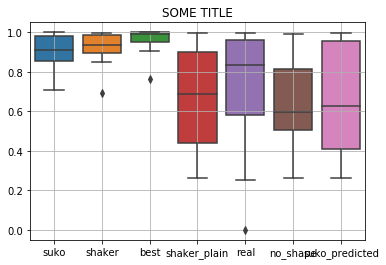

In [5]:
import pandas
import numpy as np
index= ['suko',"shaker", "best","shaker_plain",'real',"no_shape", "suko_predicted"]
data = map(lambda x: [x[k] for k in keys] ,[acc_suko, acc_shaker,acc_thoretical_best,acc_shaker_plain, acc_real, acc_noshape, acc_suko_predicted])

#import notebook_helper as nbh
#nbh.boxplotDraw(data,index,"i am the fig title","","FUCKOFF")

import seaborn as sns
sns.boxplot(data=pandas.DataFrame(data[:7], index=index[:7]).T)

plt.title("SOME TITLE")
plt.grid()

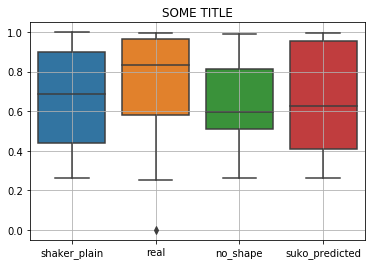

In [6]:
sns.boxplot(data=pandas.DataFrame(data[3:], index=index[3:]).T)
plt.title("SOME TITLE")
plt.grid()

In [7]:

map(lambda x:x.append(np.mean(x)),data)
df = pandas.DataFrame(data, columns=keys+['mean'], index=index).T

print df.to_latex()

\begin{tabular}{lrrrrrrr}
\toprule
{} &      suko &    shaker &      best &  shaker\_plain &      real &  no\_shape &  suko\_predicted \\
\midrule
ADDRSW     &  0.995418 &  0.994677 &  0.999629 &      0.994575 &  0.987444 &  0.872423 &        0.993141 \\
GLYCFN     &  0.933740 &  0.978361 &  0.999256 &      0.370027 &  0.000000 &  0.565605 &        0.369688 \\
tRNAphe    &  0.993876 &  0.994838 &  0.999126 &      0.783283 &  0.995362 &  0.504352 &        0.971549 \\
RNAsep     &  0.709765 &  0.694212 &  0.766092 &      0.652954 &  0.676623 &  0.530544 &        0.411861 \\
ZHCV       &  0.842766 &  0.892499 &  0.904532 &      0.895701 &  0.533042 &  0.744884 &        0.900175 \\
Z-CIDGMP-1 &  0.846538 &  0.855160 &  0.987850 &      0.724772 &  0.759976 &  0.727020 &        0.714203 \\
adenin     &  0.996870 &  0.989374 &  0.999496 &      0.989459 &  0.981553 &  0.871697 &        0.989712 \\
tRNA-asp   &  0.912563 &  0.851969 &  0.948568 &      0.497743 &  0.550157 &  0.518002 &        0

In [8]:
from tabulate import tabulate 
print tabulate(df, headers="keys", tablefmt="orgtbl")

|            |     suko |   shaker |     best |   shaker_plain |     real |   no_shape |   suko_predicted |
|------------+----------+----------+----------+----------------+----------+------------+------------------|
| ADDRSW     | 0.995418 | 0.994677 | 0.999629 |       0.994575 | 0.987444 |   0.872423 |         0.993141 |
| GLYCFN     | 0.93374  | 0.978361 | 0.999256 |       0.370027 | 0        |   0.565605 |         0.369688 |
| tRNAphe    | 0.993876 | 0.994838 | 0.999126 |       0.783283 | 0.995362 |   0.504352 |         0.971549 |
| RNAsep     | 0.709765 | 0.694212 | 0.766092 |       0.652954 | 0.676623 |   0.530544 |         0.411861 |
| ZHCV       | 0.842766 | 0.892499 | 0.904532 |       0.895701 | 0.533042 |   0.744884 |         0.900175 |
| Z-CIDGMP-1 | 0.846538 | 0.85516  | 0.98785  |       0.724772 | 0.759976 |   0.72702  |         0.714203 |
| adenin     | 0.99687  | 0.989374 | 0.999496 |       0.989459 | 0.981553 |   0.871697 |         0.989712 |
| tRNA-asp   | 0.912563 | 0.

---